In [11]:
import os

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GATConv
from torch_geometric.data import Data

import seaborn as sns
import matplotlib.pyplot as plt

In [12]:
def load_data_files(file_paths, max_files=20):
    trans_data, prote_data, geno_data = pd.DataFrame(), pd.DataFrame(), pd.DataFrame()
    trans_files, prote_files, geno_files = [], [], []

    for file in file_paths:
        if 'prote' in file and len(prote_files) < max_files:
            prote_files.append(file)
        elif 'trans' in file and len(trans_files) < max_files:
            trans_files.append(file)
        elif 'geno' in file and len(geno_files) < max_files:
            geno_files.append(file)

    for f in trans_files:
        trans_data = pd.concat([trans_data, pd.read_csv(f, sep='\t')], ignore_index=True)
    for f in prote_files:
        prote_data = pd.concat([prote_data, pd.read_csv(f, sep='\t')], ignore_index=True)
    for f in geno_files:
        geno_data = pd.concat([geno_data, pd.read_csv(f, sep='\t')], ignore_index=True)

    return trans_data, prote_data, geno_data


In [13]:
def get_cancer_files():
    cancer_files, non_cancer_files = [], []
    for file in os.listdir('data/Cancerous'):
        if file.endswith('.tsv'):
            cancer_files.append(os.path.join('data/Cancerous', file))
    for file in os.listdir('data/Non-Cancerous'):
        if file.endswith('.tsv'):
            non_cancer_files.append(os.path.join('data/Non-Cancerous', file))

    return cancer_files, non_cancer_files

In [14]:
def pre_process(trans_data,prote_data,geno_data,canval,chunk_size=5000):
  mgt = pd.merge(geno_data, trans_data, on='gene_id', how='inner')
  ma = pd.merge(mgt, prote_data,left_on='gene_name_x', right_on='peptide_target', how='inner')
  
  columns=['Unnamed: 9','Unnamed: 10','gene_name_y','set_id','catalog_number','lab_id','AGID','stranded_first','stranded_second','unstranded','gene_id','start','end','min_copy_number','max_copy_number','gene_type','unstranded']
  for i in columns:
    try:
      ma = ma.drop(columns=[i])
    except:
      pass
  ma.to_csv('all_data.csv', index=False)
  all_data_cleaned = pd.read_csv('all_data.csv')

  label_encoder = LabelEncoder()
  all_data_cleaned['gene_name'] = label_encoder.fit_transform(all_data_cleaned['gene_name_x'])
  all_data_cleaned['chromosome'] = label_encoder.fit_transform(all_data_cleaned['chromosome'])
  all_data_cleaned['peptide_target'] = label_encoder.fit_transform(all_data_cleaned['peptide_target'])

  all_data_cleaned['gene_presence'] = canval

  num_cancerous = all_data_cleaned[all_data_cleaned['gene_presence'] == 1].shape[0]
  labels = torch.tensor([1] * num_cancerous + [0] * (all_data_cleaned.shape[0] - num_cancerous), dtype=torch.float)
  all_data_cleaned = all_data_cleaned.drop(columns=['gene_name_x'])
  all_data_cleaned = all_data_cleaned.dropna()
  return all_data_cleaned,labels

In [15]:
def define_gene_presence(all_data_cleaned):
  if all_data_cleaned['gene_presence'] == 1:
    return 1
  else:
    return 0

In [16]:
def scale_train_split(all_data_cleaned):

  features = all_data_cleaned[['chromosome','copy_number','tpm_unstranded', 'fpkm_unstranded', 'fpkm_uq_unstranded', 'peptide_target', 'protein_expression', 'gene_name']]
  target = all_data_cleaned['gene_presence']
  scaler = StandardScaler()
  features_scaled = scaler.fit_transform(features)
  X,y = features_scaled,target
  X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)
  X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
  y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
  X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
  y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)
  return X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor

In [17]:
def GAT_pre_process(all_data_cleaned):
  all_data_cleaned['gene_presence'] = all_data_cleaned.apply(define_gene_presence, axis=1)
  features = all_data_cleaned[['chromosome','copy_number','tpm_unstranded', 'fpkm_unstranded', 'fpkm_uq_unstranded', 'peptide_target', 'protein_expression', 'gene_name']].fillna(0)
  correlation_matrix = features.corr()

  plt.figure(figsize=(10, 8))
  sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})
  plt.title("Correlation Matrix")
  plt.show()

  threshold = 0.8
  edges = []
  edge_attributes = []

  for i in range(len(correlation_matrix.columns)):
      for j in range(i):
          corr_value = correlation_matrix.iloc[i, j]
          if abs(corr_value) > threshold:
              edges.append([features.columns.get_loc(correlation_matrix.columns[i]),
                            features.columns.get_loc(correlation_matrix.columns[j])])
              edge_attributes.append(abs(corr_value))

  edge_index = np.array(edges).T
  edge_attributes = np.array(edge_attributes)

  print("Edge Index:")
  print(edge_index)
  print("Edge Attributes (Weights):")
  print(edge_attributes)

  return edge_index, edge_attributes

In [ ]:
can,cannot = get_cancer_files()
cantrans,canprote,cangeno = load_data_files(can)
notcantrans,notcanprote,notcangeno = load_data_files(cannot)

allcan,canlab = pre_process(cantrans,canprote,cangeno,1)
allnotcan,notcanlab = pre_process(notcantrans,notcanprote,notcangeno,0)
    
all_data_cleaned = pd.concat([allcan,allnotcan])
labels = torch.cat((canlab,notcanlab), dim=0)

X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor = scale_train_split(all_data_cleaned)

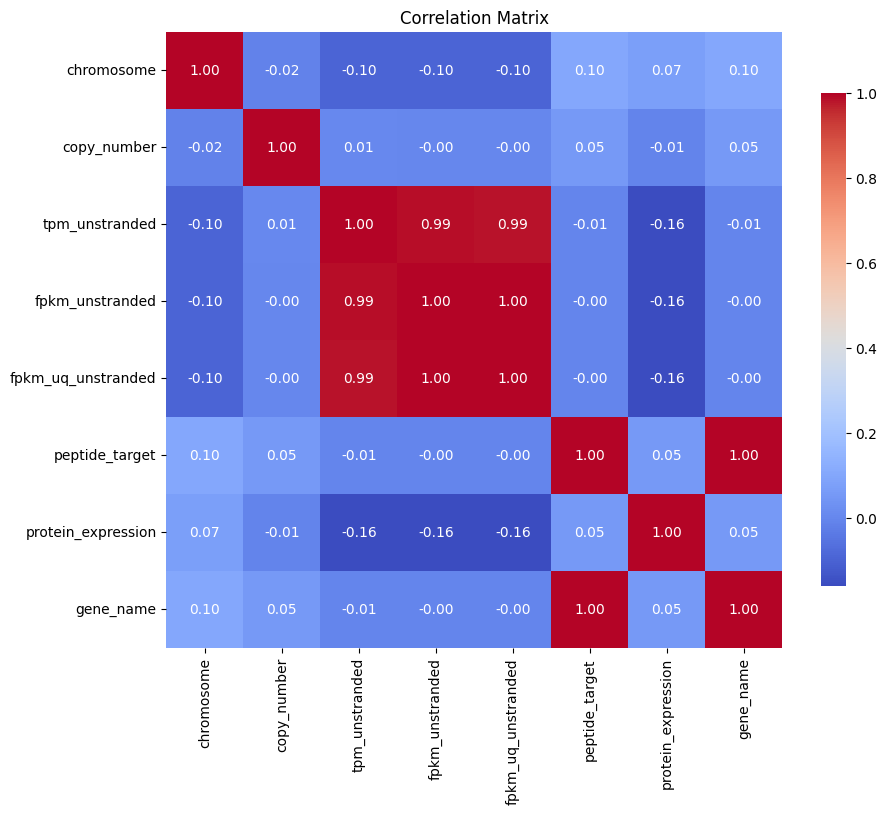

Edge Index:
[[3 4 4 7]
 [2 2 3 5]]
Edge Attributes (Weights):
[0.98890417 0.98597653 0.99606533 1.        ]


In [ ]:
edge_index,edge_attribute = GAT_pre_process(all_data_cleaned)

In [ ]:
edge_weights = edge_attribute
edge_index = torch.tensor(edge_index)

In [ ]:
class GATWithDimensionalityReduction(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, reduce_dim, num_heads=4):
        super(GATWithDimensionalityReduction, self).__init__()
        self.conv1 = GATConv(in_channels, hidden_channels, heads=num_heads, edge_dim=1)
        self.conv2 = GATConv(hidden_channels * num_heads, hidden_channels * 2, heads=num_heads, edge_dim=1)
        self.conv3 = GATConv(hidden_channels * 2 * num_heads, hidden_channels * 4, heads=num_heads, edge_dim=1)
        self.conv4 = GATConv(hidden_channels * 4 * num_heads, hidden_channels * 8, heads=num_heads, edge_dim=1)

        self.dim_reduce = nn.Linear(hidden_channels * 8 * num_heads, reduce_dim)

        self.fc1 = nn.Linear(reduce_dim, 64)
        self.fc2 = nn.Linear(64, 1)

    def forward(self, x, edge_index, edge_attr):
        x = F.elu(self.conv1(x, edge_index))
        x = F.elu(self.conv2(x, edge_index))
        x = F.elu(self.conv3(x, edge_index))
        x = F.elu(self.conv4(x, edge_index))

        x = self.dim_reduce(x)
        x = F.elu(x)

        x = F.elu(self.fc1(x))
        x = self.fc2(x)

        return x

torch.manual_seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

X_train_tensor = torch.tensor(X_train_tensor).float().to(device)
y_train_tensor = torch.tensor(y_train_tensor).float().to(device)
X_test_tensor = torch.tensor(X_test_tensor).float().to(device)
y_test_tensor = torch.tensor(y_test_tensor).float().to(device)
edge_index = torch.tensor(edge_index).long().to(device)
edge_weights = torch.tensor(edge_weights).float().to(device)

in_channels = X_train_tensor.shape[1]
hidden_channels = 8
out_channels = 16
reduce_dim = 32
num_heads = 4

model1 = GATWithDimensionalityReduction(in_channels=in_channels, hidden_channels=hidden_channels, out_channels=out_channels, reduce_dim=reduce_dim, num_heads=num_heads).to(device)

train_data = Data(x=X_train_tensor, edge_index=edge_index, edge_attr=edge_weights, y=y_train_tensor)
test_data = Data(x=X_test_tensor, edge_index=edge_index, edge_attr=edge_weights, y=y_test_tensor)

optimizer = torch.optim.Adam(model1.parameters(), lr=0.001)
criterion = nn.BCEWithLogitsLoss()

num_epochs = 100
for epoch in range(num_epochs):
    model1.train()
    optimizer.zero_grad()
    out = model1(train_data.x, train_data.edge_index, train_data.edge_attr)
    out = out.view(-1)
    loss = criterion(out, train_data.y)
    loss.backward()
    optimizer.step()

    if((epoch+1) % 10 == 0):
        print(f'Epoch {epoch+1}, Loss: {loss.item()}')

model1.eval()
with torch.no_grad():
    test_out = model1(test_data.x, test_data.edge_index, test_data.edge_attr).view(-1)
    test_loss = criterion(test_out, test_data.y)
    print(f'Test Loss: {test_loss.item():.4f}')
    predictions = torch.sigmoid(test_out) > 0.5
    accuracy = (predictions.float() == test_data.y).float().mean()
    print(f'Test Accuracy: {accuracy.item() * 100:.2f}%')


Using device: cuda


C:\Users\Jayan\AppData\Local\Temp\ipykernel_7556\2953839388.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train_tensor = torch.tensor(X_train_tensor).float().to(device)
C:\Users\Jayan\AppData\Local\Temp\ipykernel_7556\2953839388.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_tensor = torch.tensor(y_train_tensor).float().to(device)
C:\Users\Jayan\AppData\Local\Temp\ipykernel_7556\2953839388.py:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test_tensor = torch.tensor(X_test_tensor).float().to(device)
C:\Users\Jay

Epoch 1, Loss: 0.7275857925415039
Epoch 2, Loss: 0.7074714303016663
Epoch 3, Loss: 0.6884336471557617
Epoch 4, Loss: 0.6690865755081177
Epoch 5, Loss: 0.648527979850769
Epoch 6, Loss: 0.6260961890220642
Epoch 7, Loss: 0.6013876795768738
Epoch 8, Loss: 0.5742700099945068
Epoch 9, Loss: 0.5448886156082153
Epoch 10, Loss: 0.5136879086494446
Epoch 11, Loss: 0.481400728225708
Epoch 12, Loss: 0.4489729702472687
Epoch 13, Loss: 0.41743120551109314
Epoch 14, Loss: 0.3877646327018738
Epoch 15, Loss: 0.3608834147453308
Epoch 16, Loss: 0.3376516103744507
Epoch 17, Loss: 0.3190000653266907
Epoch 18, Loss: 0.3060406446456909
Epoch 19, Loss: 0.2997817397117615
Epoch 20, Loss: 0.3001193702220917
Epoch 21, Loss: 0.30484265089035034
Epoch 22, Loss: 0.31014493107795715
Epoch 23, Loss: 0.31341123580932617
Epoch 24, Loss: 0.3144785463809967
Epoch 25, Loss: 0.3144376575946808
Epoch 26, Loss: 0.31390756368637085
Epoch 27, Loss: 0.31251704692840576
Epoch 28, Loss: 0.3097308576107025
Epoch 29, Loss: 0.3055919

In [ ]:
torch.save(model1.state_dict(), "GATWithDimensionalityReduction.pth")
print("Model saved successfully!")

Model saved successfully!
